In [1]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
from scipy import stats
import celloracle as co
import os
import sys
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import math
from celloracle.applications import Oracle_development_module
from tqdm.notebook import tqdm

plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600
%matplotlib inline

which: no R in (/bgfs/rgottschalk/Sonia/envs/celloracle_new/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin/:/ihome/rgottschalk/sok65/.local/bin:/ihome/rgottschalk/sok65/bin)
/bgfs/rgottschalk/Sonia/envs/celloracle_new/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
def make_ps_df(helper, net_data_means, topics, chrombpnetTFs):
    neg_ps_dict = dict()
    pos_ps_dict = dict()
    for k in topics:
        neg_ps = helper.calculate_negative_ps_p_value(misc=k)
        pos_ps = helper.calculate_positive_ps_p_value(misc=k)
        neg_ps_dict[k] = pd.Series(data=list(neg_ps['ps_sum']), index=neg_ps['gene'])
        pos_ps_dict[k] = pd.Series(data=list(pos_ps['ps_sum']), index=pos_ps['gene'])
    neg_ps = pd.DataFrame(data=neg_ps_dict)
    pos_ps = pd.DataFrame(data=pos_ps_dict)
    ps_df = pos_ps.merge(neg_ps, left_index=True, right_on=['gene'], suffixes=['_pos', '_neg'])
    ps_df = pd.concat([ps_df, net_data_means], axis=1)
    ps_df['chrombpnet'] = list(ps_df.reset_index()['index'].apply(lambda x: x in chrombpnetTFs))
    return ps_df

def getNetTopicPS(ps_df):
    ps_df['k4_net'] = ps_df['k4_pos'] - ps_df['k4_neg']
    ps_df['k5_net'] = ps_df['k5_pos'] - ps_df['k5_neg']
    ps_df['k7_net'] = ps_df['k7_pos'] - ps_df['k7_neg']
    return ps_df

def plot_ps(df, xcol, ycol, metric = 'eigenvector_centrality',  thresh = 15, size_factor = 200, color_metric = 'chrombpnet', color = 'blue', ax_size=(0,70), labels=True, alpha=1, title=''):
    fig, ax = plt.subplots(figsize=[8, 8])
    temp = df.loc[:, [xcol, ycol, metric, color_metric]].reset_index()
    metric_rescaled = temp[metric] * size_factor
    temp[metric] = metric_rescaled
    if type(color) == str:
        color = [color] * 2
    temp[color_metric] = temp[color_metric].astype(int).apply(lambda x: color[x])
    ax.scatter(temp[xcol], temp[ycol], s = temp[metric], facecolors='none', edgecolors=temp[color_metric], alpha=alpha, zorder=5)
    for idx, (gene, x, y, metric, chrombpnet) in temp.iterrows():
        if (x > thresh) | (y > thresh):
            if labels == True:
                ax.text(s=gene, x=x, y=y, zorder=10)
            else:
                try:
                    it = iter(labels)
                    if gene in labels:
                        ax.text(s=gene, x=x, y=y, zorder=10)
                    else:
                        ax.text(s='', x=x, y=y, zorder=10)
                except TypeError:
                    ax.text(s='', x=x, y=y, zorder=10)
    ax_size = ax_size * 2
    plt.ylabel(ycol)
    plt.xlabel(xcol)
    plt.xlim(ax_size[0], ax_size[1])
    plt.ylim(ax_size[2], ax_size[3])
    plt.title(title)
    return ax

def plot_ps_3D(df, xcol, ycol, zcol, metric = 'eigenvector_centrality',  thresh = 15, size_factor = 200, color = 'blue', ax_size=(0,70), labels=True, alpha=1):
    fig, ax = plt.subplots(figsize=[8, 8], subplot_kw={"projection": "3d"})
    temp = df.loc[:, [xcol, ycol, zcol, metric, 'chrombpnet']].reset_index()
    metric_rescaled = temp[metric] * size_factor
    temp[metric] = metric_rescaled
    if type(color) == str:
        color = [color] * 2
    temp['chrombpnet'] = temp['chrombpnet'].apply(lambda x: color[0] if (x == True) else color[1])
    ax.scatter(temp[xcol], temp[ycol], temp[zcol], facecolors='none', edgecolors=color, alpha=alpha, zorder=5)
    for idx, (gene, x, y, z, metric, chrombpnet) in temp.iterrows():
        if (x > thresh) | (y > thresh):
            if labels == True:
                ax.text(s=gene, x=x, y=y, z=z, zorder=10)
            else:
                try:
                    it = iter(labels)
                    if gene in labels:
                        ax.text(s=gene, x=x, y=y, z=z,  zorder=10)
                    else:
                        ax.text(s='', x=x, y=y, z=z, zorder=10)
                except TypeError:
                    ax.text(s='', x=x, y=y, z=z, zorder=10)
    ax_size = ax_size * 3
    plt.ylabel(ycol)
    plt.xlabel(xcol)
    plt.zlabel(xcol)
    plt.xlim(ax_size[0], ax_size[1])
    plt.ylim(ax_size[2], ax_size[3])
    plt.zlim(ax_size[4], ax_size[5])
    return ax

def getVectors(df, xcol, ycol, zcol=None):
    vector_lengths = dict()
    try:
        temp = df.loc[:, [xcol, ycol, zcol]].reset_index()
        for idx, (gene, x, y, z) in temp.iterrows():
            vector_length = math.sqrt((x)**2 + (y)**2 + (z)**2)
            vector_lengths[gene] = vector_length
    except KeyError:
        temp = df.loc[:, [xcol, ycol]].reset_index()
        for idx, (gene, x, y) in temp.iterrows():
            vector_length = math.sqrt((x)**2 + (y)**2)
            vector_lengths[gene] = vector_length
    top_vectors = pd.Series(vector_lengths).sort_values(ascending=False)
    return top_vectors

def plot_ps_quadrants(df, xcol, ycol, metric = 'eigenvector_centrality', color_metric = 'chrombpnet', thresh = 20, color='blue', size_factor= 200, ax_size=(0, 60), labels=True, arrow_color = 'black', alpha=1, title=''):
    if type(labels) == int:
        top_vectors = getVectors(df, xcol, ycol)[:labels].index
        labels = list(top_vectors)
    temp = df.loc[:, [xcol, ycol, metric, color_metric]].reset_index()
    ax = plot_ps(df = df, xcol = xcol, ycol=ycol, metric=metric, color_metric = color_metric, thresh=thresh, color=color, size_factor=size_factor, ax_size=ax_size, labels=labels, alpha=alpha, title=title)
    for idx, (gene, x, y, metric, chrombpnet) in temp.iterrows():
        ax.annotate("", xytext=(0, 0), xy=(x, y), arrowprops={'color': arrow_color, 'arrowstyle':"->"}, alpha=0.2, zorder=0)
    plt.axhline(y=0, color='black', linestyle='-')
    plt.axvline(x=0, color='black', linestyle='-')

def plot_ps_quadrants_layered(df_select, df, xcol, ycol, metric = 'eigenvector_centrality', color_metric = 'chrombpnet', thresh = 20, color='blue', size_factor= 200, ax_size=(0, 60), labels=True, arrow_color = 'black', alpha=0.4, title=''):
    plot_ps_quadrants(df = df, xcol=xcol, ycol=ycol, metric = metric, thresh = thresh, color=color, size_factor= size_factor, ax_size=ax_size, labels=labels, arrow_color = arrow_color, alpha=alpha, title=title)

In [ ]:
df, 
xcol, 
ycol, 
metric = 'eigenvector_centrality'
color_metric = 'chrombpnet', thresh = 20, color='blue', size_factor= 200, ax_size=(0, 60), labels=True, arrow_color = 'black', alpha=1
title=''

fig, ax = plt.subplots(figsize=[8, 8])
temp = df.loc[:, [xcol, ycol, metric, color_metric]].reset_index()
metric_rescaled = temp[metric] * size_factor
temp[metric] = metric_rescaled
if type(color) == str:
    color = [color] * 2
temp[color_metric] = temp[color_metric].astype(int).apply(lambda x: color[x])
ax.scatter(temp[xcol], temp[ycol], s = temp[metric], facecolors='none', edgecolors=temp[color_metric], alpha=alpha, zorder=5)
for idx, (gene, x, y, metric, chrombpnet) in temp.iterrows():
    if (x > thresh) | (y > thresh):
        if labels == True:
            ax.text(s=gene, x=x, y=y, zorder=10)
        else:
            try:
                it = iter(labels)
                if gene in labels:
                    ax.text(s=gene, x=x, y=y, zorder=10)
                else:
                    ax.text(s='', x=x, y=y, zorder=10)
            except TypeError:
                ax.text(s='', x=x, y=y, zorder=10)
ax_size = ax_size * 2
plt.ylabel(ycol)
plt.xlabel(xcol)
plt.xlim(ax_size[0], ax_size[1])
plt.ylim(ax_size[2], ax_size[3])
plt.title(title)

In [3]:
RAM_path = "20251213_Systematic_simulation_results_RAM.celloracle.hdf5"
MoM_path = "20251216_Systematic_simulation_results_MoM.celloracle.hdf5"
RAMdev = Oracle_development_module()
RAMdev.set_hdf_path(path=RAM_path)
RAMinfo = RAMdev.get_hdf5_info()

print("Genes\n", RAMinfo["gene_list"])
print("\nSimulation conditions\n", RAMinfo["misc_list"])

Genes
 ['Arid2' 'Arid3a' 'Arnt' 'Arntl' 'Atf1' 'Atf3' 'Atf7' 'Bach1' 'Bcl6'
 'Bclaf1' 'Bhlhe40' 'Bhlhe41' 'Cbfb' 'Cdc5l' 'Cebpa' 'Cebpb' 'Cebpg'
 'Cebpz' 'Clock' 'Creb1' 'Ctcf' 'Cux1' 'E2f4' 'E2f7' 'E2f8' 'E4f1' 'Ebf1'
 'Egr1' 'Egr2' 'Egr4' 'Elf1' 'Elf2' 'Elf4' 'Elf5' 'Epas1' 'Erg' 'Esrra'
 'Ets1' 'Etv6' 'Ezh2' 'Fli1' 'Fos' 'Foxa3' 'Foxj2' 'Foxj3' 'Foxk1' 'Foxk2'
 'Foxl1' 'Foxm1' 'Foxo1' 'Foxo3' 'Foxp1' 'Foxp4' 'Gabpa' 'Gata1' 'Gata2'
 'Gcm1' 'Gmeb2' 'Gtf2i' 'Hic2' 'Hivep2' 'Hivep3' 'Hoxa6' 'Hoxa9' 'Hoxd3'
 'Hsf1' 'Id3' 'Ikzf1' 'Ikzf3' 'Ikzf4' 'Irf2' 'Irf3' 'Irf4' 'Irf5' 'Irf7'
 'Irf8' 'Irf9' 'Jun' 'Junb' 'Jund' 'Klf13' 'Klf4' 'Lef1' 'Maf' 'Mafb'
 'Maff' 'Mafg' 'Mafk' 'Max' 'Maz' 'Mbd1' 'Mbd2' 'Mbtps2' 'Mecp2' 'Mef2a'
 'Mef2b' 'Mef2c' 'Mef2d' 'Mga' 'Mitf' 'Mlx' 'Mlxip' 'Mnt' 'Mtf1' 'Mybl1'
 'Mycn' 'Myef2' 'Nanog' 'Neurod1' 'Neurog2' 'Nfat5' 'Nfatc1' 'Nfatc3'
 'Nfatc4' 'Nfia' 'Nfib' 'Nfic' 'Nfix' 'Nfkb1' 'Nfkb2' 'Nfya' 'Nfyb' 'Nfyc'
 'Nhlh1' 'Nkx2-4' 'Npas2' 'Nr2c1' 'Nr2c2' 'Nr3c1' 'Nr4

In [4]:
MoMdev = Oracle_development_module()
MoMdev.set_hdf_path(path=MoM_path)
MoMinfo = MoMdev.get_hdf5_info()

print("Genes\n", MoMinfo["gene_list"])
print("\nSimulation conditions\n", MoMinfo["misc_list"])

Genes
 ['Arid2' 'Arid3a' 'Arnt' 'Arntl' 'Atf1' 'Atf3' 'Atf7' 'Bach1' 'Bcl6'
 'Bclaf1' 'Bhlhe40' 'Bhlhe41' 'Cbfb' 'Cdc5l' 'Cebpa' 'Cebpb' 'Cebpg'
 'Cebpz' 'Clock' 'Creb1' 'Ctcf' 'Cux1' 'E2f4' 'E2f7' 'E2f8' 'E4f1' 'Ebf1'
 'Egr1' 'Egr2' 'Egr4' 'Elf1' 'Elf2' 'Elf4' 'Elf5' 'Epas1' 'Erg' 'Esrra'
 'Ets1' 'Etv6' 'Ezh2' 'Fli1' 'Fos' 'Foxa3' 'Foxj2' 'Foxj3' 'Foxk1' 'Foxk2'
 'Foxl1' 'Foxm1' 'Foxo1' 'Foxo3' 'Foxp1' 'Foxp4' 'Gabpa' 'Gata1' 'Gata2'
 'Gcm1' 'Gmeb2' 'Gtf2i' 'Hic2' 'Hivep2' 'Hivep3' 'Hoxa6' 'Hoxa9' 'Hoxd3'
 'Hsf1' 'Id3' 'Ikzf1' 'Ikzf3' 'Ikzf4' 'Irf2' 'Irf3' 'Irf4' 'Irf5' 'Irf7'
 'Irf8' 'Irf9' 'Jun' 'Junb' 'Jund' 'Klf13' 'Klf4' 'Lef1' 'Maf' 'Mafb'
 'Maff' 'Mafg' 'Mafk' 'Max' 'Maz' 'Mbd1' 'Mbd2' 'Mbtps2' 'Mecp2' 'Mef2a'
 'Mef2b' 'Mef2c' 'Mef2d' 'Mga' 'Mitf' 'Mlx' 'Mlxip' 'Mnt' 'Mtf1' 'Mybl1'
 'Mycn' 'Myef2' 'Nanog' 'Neurod1' 'Neurog2' 'Nfat5' 'Nfatc1' 'Nfatc3'
 'Nfatc4' 'Nfia' 'Nfib' 'Nfic' 'Nfix' 'Nfkb1' 'Nfkb2' 'Nfya' 'Nfyb' 'Nfyc'
 'Nhlh1' 'Nkx2-4' 'Npas2' 'Nr2c1' 'Nr2c2' 'Nr3c1' 'Nr4

In [5]:
chrombpnetTFs = {'Alx1',
 'Alx4',
 'Arnt',
 'Arnt2',
 'Arx',
 'Atf3',
 'Atf4',
 'Bach1',
 'Bach2',
 'Batf',
 'Batf3',
 'Bhlhe40',
 'Bhlhe41',
 'Bnc2',
 'Bsx',
 'Cebpa',
 'Cebpb',
 'Cebpd',
 'Cebpe',
 'Cebpg',
 'Clock',
 'Creb3l2',
 'Crx',
 'Ctcf',
 'Dbp',
 'Dlx1',
 'Dlx2',
 'Dlx4',
 'Dlx5',
 'Dmbx1',
 'Dmrt3',
 'Dmrta1',
 'Dmrta2',
 'Egr1',
 'Egr2',
 'Egr3',
 'Egr4',
 'Ehf',
 'Elf1',
 'Elf2',
 'Elf3',
 'Elf4',
 'Elf5',
 'Elk1',
 'Elk3',
 'Elk4',
 'Emx1',
 'Emx2',
 'En1',
 'En2',
 'Epas1',
 'Erf',
 'Erg',
 'Esx1',
 'Ets1',
 'Ets2',
 'Etv1',
 'Etv2',
 'Etv3',
 'Etv4',
 'Etv5',
 'Etv6',
 'Evx1',
 'Fli1',
 'Fos',
 'Fosl1',
 'Fosl2',
 'Gabpa',
 'Gbx1',
 'Gli1',
 'Gli2',
 'Gsc',
 'Hes1',
 'Hes2',
 'Hes5',
 'Hes6',
 'Hes7',
 'Hesx1',
 'Hey1',
 'Hey2',
 'Hif1a',
 'Hlf',
 'Hmx2',
 'Hoxa1',
 'Hoxa2',
 'Hoxa3',
 'Hoxa4',
 'Hoxa5',
 'Hoxa7',
 'Hoxb2',
 'Hoxb3',
 'Hoxb4',
 'Hoxb5',
 'Hoxb6',
 'Hoxb7',
 'Hoxb8',
 'Hoxc4',
 'Hoxd3',
 'Hoxd4',
 'Hoxd8',
 'Ikzf1',
 'Ikzf3',
 'Isl1',
 'Isl2',
 'Jdp2',
 'Jun',
 'Junb',
 'Jund',
 'Klf1',
 'Klf10',
 'Klf11',
 'Klf12',
 'Klf14',
 'Klf15',
 'Klf16',
 'Klf2',
 'Klf3',
 'Klf4',
 'Klf5',
 'Klf6',
 'Klf7',
 'Klf9',
 'Lbx2',
 'Lhx1',
 'Lhx2',
 'Lhx4',
 'Lhx6',
 'Lhx9',
 'Lmx1b',
 'Maf',
 'Mafa',
 'Mafg',
 'Mafk',
 'Max',
 'Maz',
 'Meis1',
 'Meis2',
 'Meis3',
 'Meox1',
 'Meox2',
 'Mitf',
 'Mixl1',
 'Mlx',
 'Mlxip',
 'Mlxipl',
 'Mnt',
 'Msx1',
 'Msx2',
 'Msx3',
 'Mxi1',
 'Myc',
 'Mycn',
 'Nanog',
 'Nfe2',
 'Nfe2l2',
 'Nfil3',
 'Nfya',
 'Nfyb',
 'Nfyc',
 'Nobox',
 'Npas2',
 'Npas4',
 'Nrf1',
 'Otx1',
 'Otx2',
 'Patz1',
 'Pax5',
 'Pbx3',
 'Phox2a',
 'Phox2b',
 'Pitx1',
 'Pitx2',
 'Pitx3',
 'Pknox1',
 'Pou6f1',
 'Pparg',
 'Prrx1',
 'Prrx2',
 'Rfx1',
 'Rfx2',
 'Rfx3',
 'Rfx4',
 'Rfx5',
 'Rfx7',
 'Runx1',
 'Runx2',
 'Runx3','Satb1','Shox2','Six3','Sohlh2','Sp1','Sp2','Sp3','Sp4','Sp5','Sp8','Sp9','Spdef','Spi1','Spib','Spic','Srebf1','Srebf2','Stat5b','Tcfl5','Tef','Tfe3','Tfeb','Tfec','Tlx2','Uncx','Usf1','Usf2','Vax1','Vax2','Vezf1','Vsx1','Vsx2','Wt1','Zbed4','Zbtb11','Zbtb14','Zbtb2','Zbtb7a','Zbtb7b','Zbtb7c'}

In [6]:
from celloracle.applications import Oracle_systematic_analysis_helper
RAMhelper = Oracle_systematic_analysis_helper(hdf5_file_path=RAM_path)
MoMhelper = Oracle_systematic_analysis_helper(hdf5_file_path=MoM_path)

In [7]:
RAMhelper.interactive_sort_TFs_by_neagative_ip()

interactive(children=(Dropdown(description='misc', options=('k4', 'k5', 'k7'), value='k4'), Text(value='0,1,2,…

In [8]:
MoMhelper.interactive_sort_TFs_by_neagative_ip()

interactive(children=(Dropdown(description='misc', options=('k4', 'k5', 'k7'), value='k4'), Text(value='0,1,2,…

In [7]:
network_file = '20251111_links/20251111_MoMRAM_GSE280003_chrombpnetCellOracle_networkData.csv'
network_data = pd.read_csv(network_file, index_col=0)
network_data['cellType'] = network_data['cluster'].apply(lambda x: x[-3:])
network_data['time'] = network_data['cluster'].apply(lambda x: x[-7:-4])
net_data_RAMmeans = network_data.query('degree_out != 0').query('cellType == "RAM"').reset_index()
net_data_RAMmeans = net_data_RAMmeans.groupby('index').agg('mean', numeric_only=True)
net_data_MoMmeans = network_data.query('degree_out != 0').query('cellType == "MoM"').reset_index()
net_data_MoMmeans = net_data_MoMmeans.groupby('index').agg('mean', numeric_only=True)

In [8]:
topics = ['k4', 'k5', 'k7']


RAM_ps_df = make_ps_df(RAMhelper, net_data_RAMmeans, topics, chrombpnetTFs)
MoM_ps_df = make_ps_df(MoMhelper, net_data_MoMmeans, topics, chrombpnetTFs)


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

In [9]:
RAM_ps_df = getNetTopicPS(RAM_ps_df)
MoM_ps_df = getNetTopicPS(MoM_ps_df)

2025-12-17 14:17:41,805 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-17 14:17:41,808 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


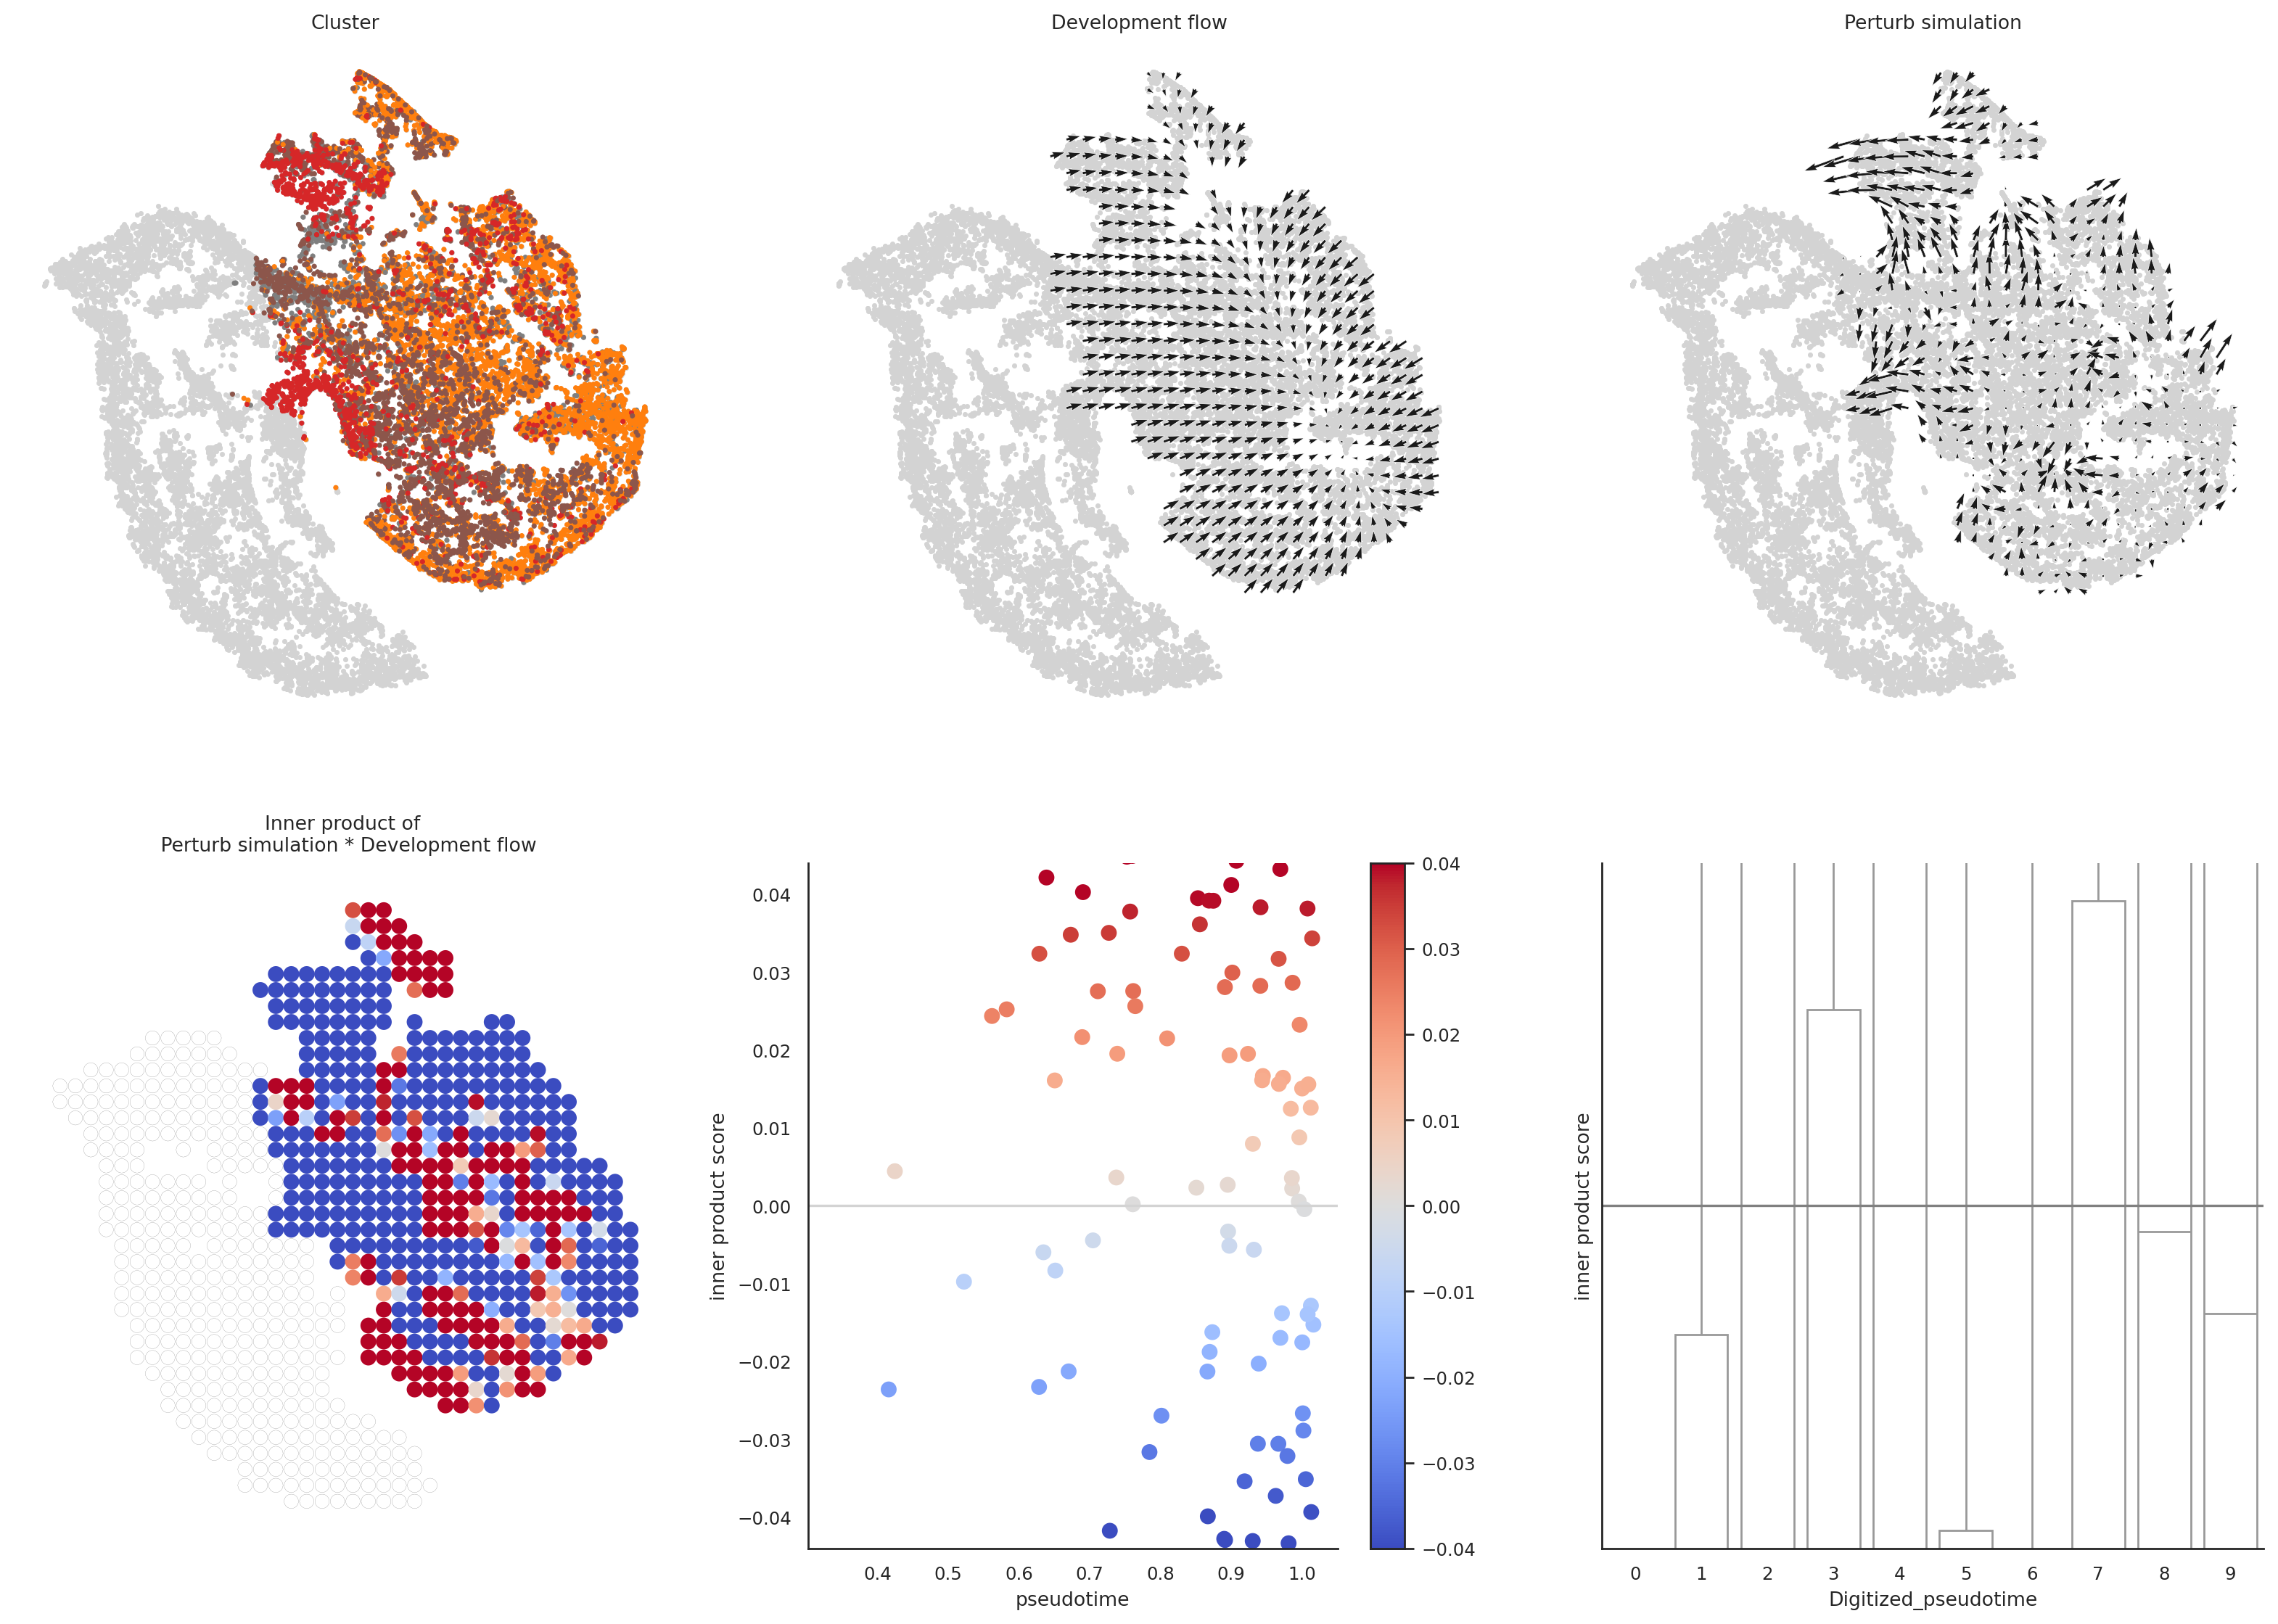

In [140]:
from celloracle.visualizations.config import CONFIG
CONFIG["cmap_ps"] = "coolwarm"

dev_test = Oracle_development_module()

# Read result
dev_test.set_hdf_path(path=RAM_path)
dev_test.load_hdf5(gene="Cebpb", misc="k7")

# Visualize result
dev_test.visualize_development_module_layout_0(s=5, scale_for_simulation=15, s_grid=50,
                                          scale_for_pseudotime=40, vm=0.04)

In [10]:
core = {'Cebpb', 'Spi1'}
RAM_ps_df_filt = RAM_ps_df.query('index in @core')
MoM_ps_df_filt = MoM_ps_df.query('index in @core')

def colorCoding(x):
    if x in core:
        return 0
    elif x in inflam:
        return 1
    elif x in homeo:
        return 2
    else:
        return 3

RAM_ps_df_filt['color_code'] = list(RAM_ps_df_filt.reset_index()['index'].apply(lambda x: colorCoding(x)))
MoM_ps_df_filt['color_code'] = list(MoM_ps_df_filt.reset_index()['index'].apply(lambda x: colorCoding(x)))
one = RAM_ps_df_filt.loc[['Cebpb','Spi1']]
two = MoM_ps_df_filt.loc[['Cebpb','Spi1']]
two['color_code'] = [1, 1]
justcoreDF = pd.concat([one, two])

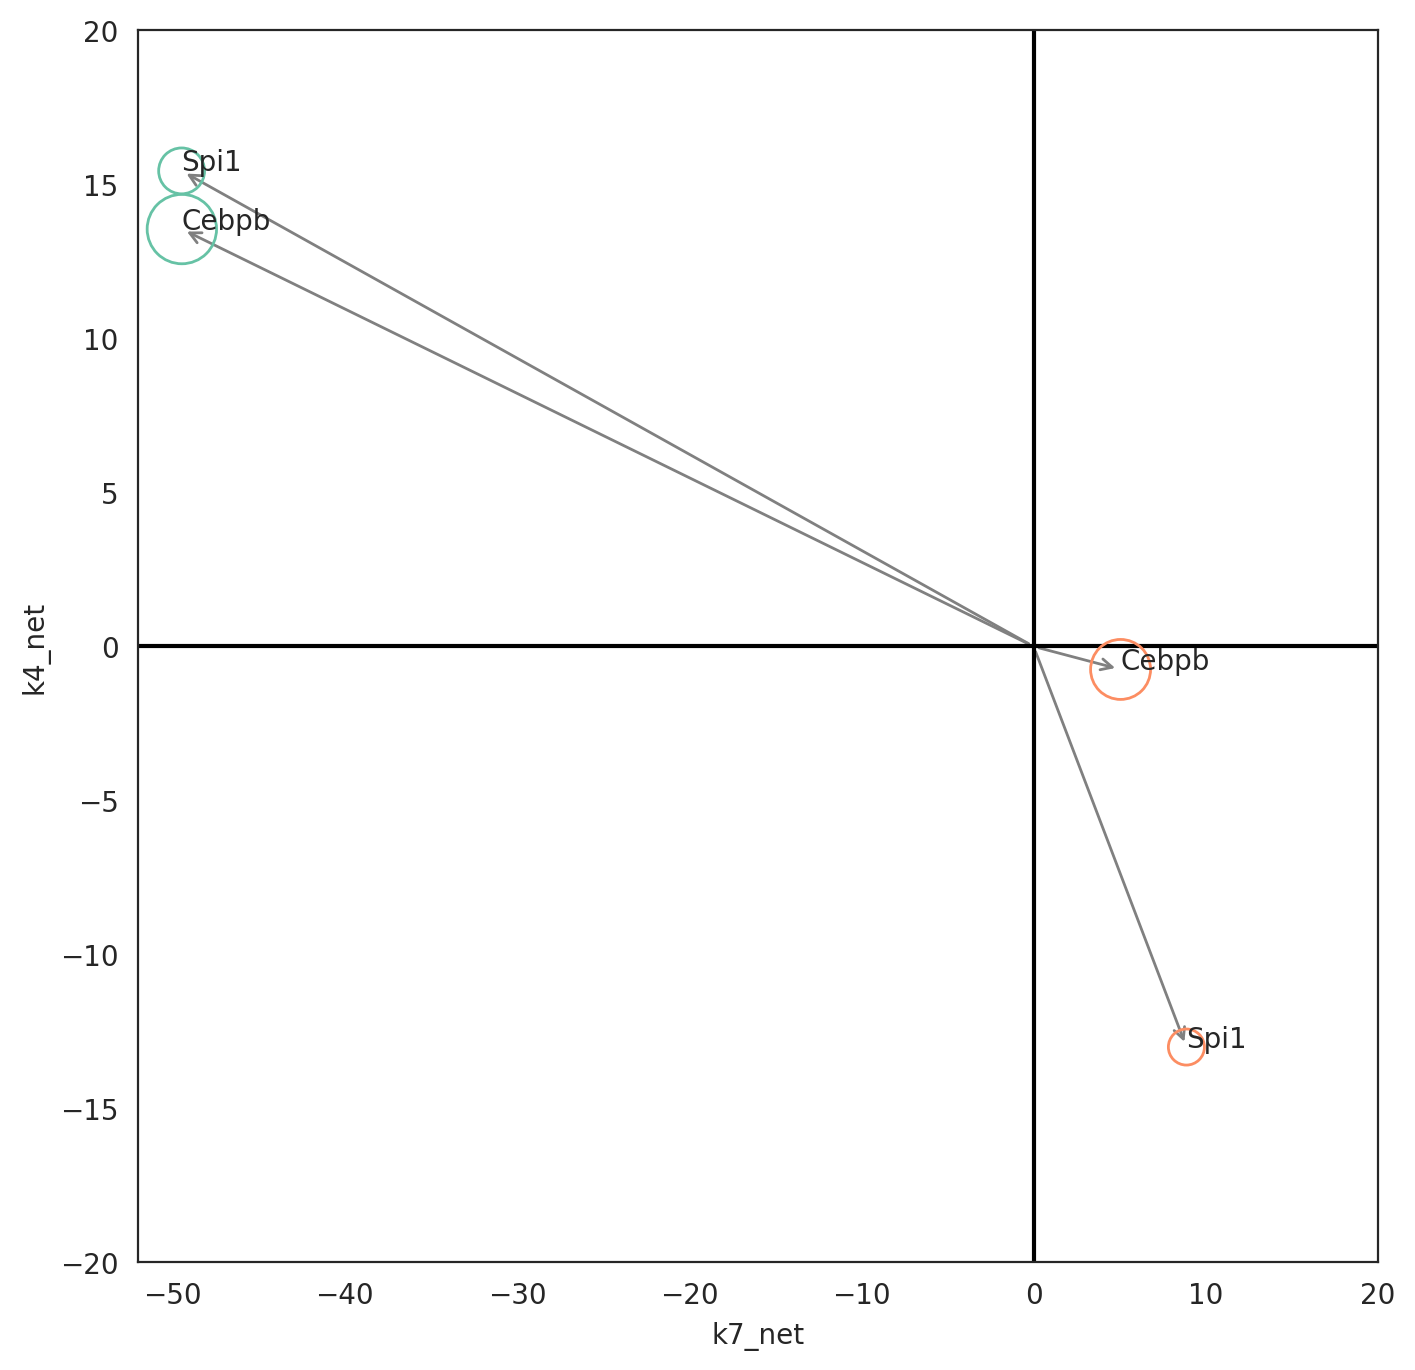

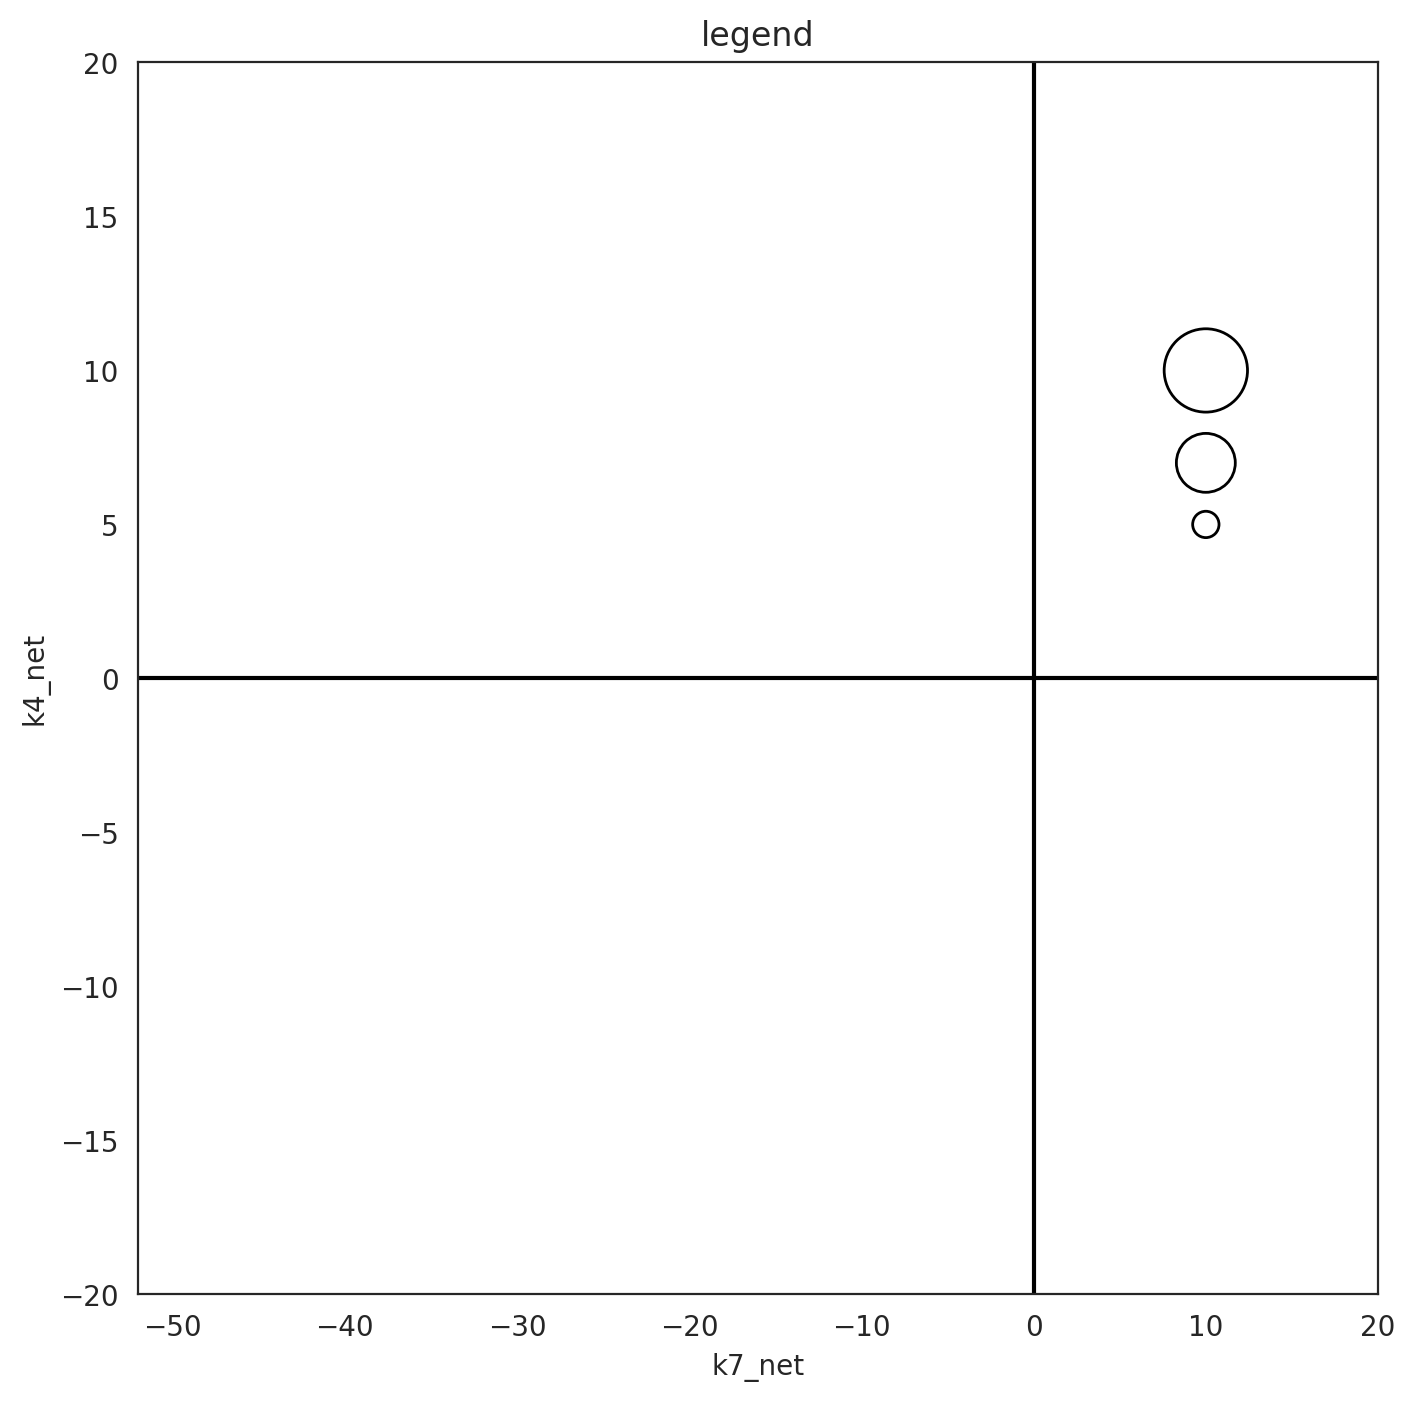

In [45]:
legenddata = pd.DataFrame(dict(zip(MoM_ps_df_filt.columns, (([[0] * 3] * len(MoM_ps_df_filt.columns))))), index = ['Eigenvector.01', 'Eigenvector.1', 'Eigenvector1'])
legenddata['eigenvector_centrality'] = [0.1, 0.5, 1]
legenddata['k7_net'] = [10, 10, 10]
legenddata['k4_net'] = [5, 7, 10]
plot_ps_quadrants(justcoreDF, 'k7_net','k4_net', color=['#66c2a5', '#fc8d62'], color_metric = 'color_code', size_factor=900, ax_size=(-52, 20, -20, 20), thresh=-100, arrow_color='grey')
#plt.savefig('20260108_cebpb_spi1_momram_vectorquads.pdf')
plot_ps_quadrants(legenddata, 'k7_net','k4_net', color='black', size_factor=900, ax_size=(-52, 20, -20, 20), arrow_color='white', labels=True, title='legend')
#plt.savefig('20260108_cebpb_spi1_momram_vectorquads_legend.pdf')

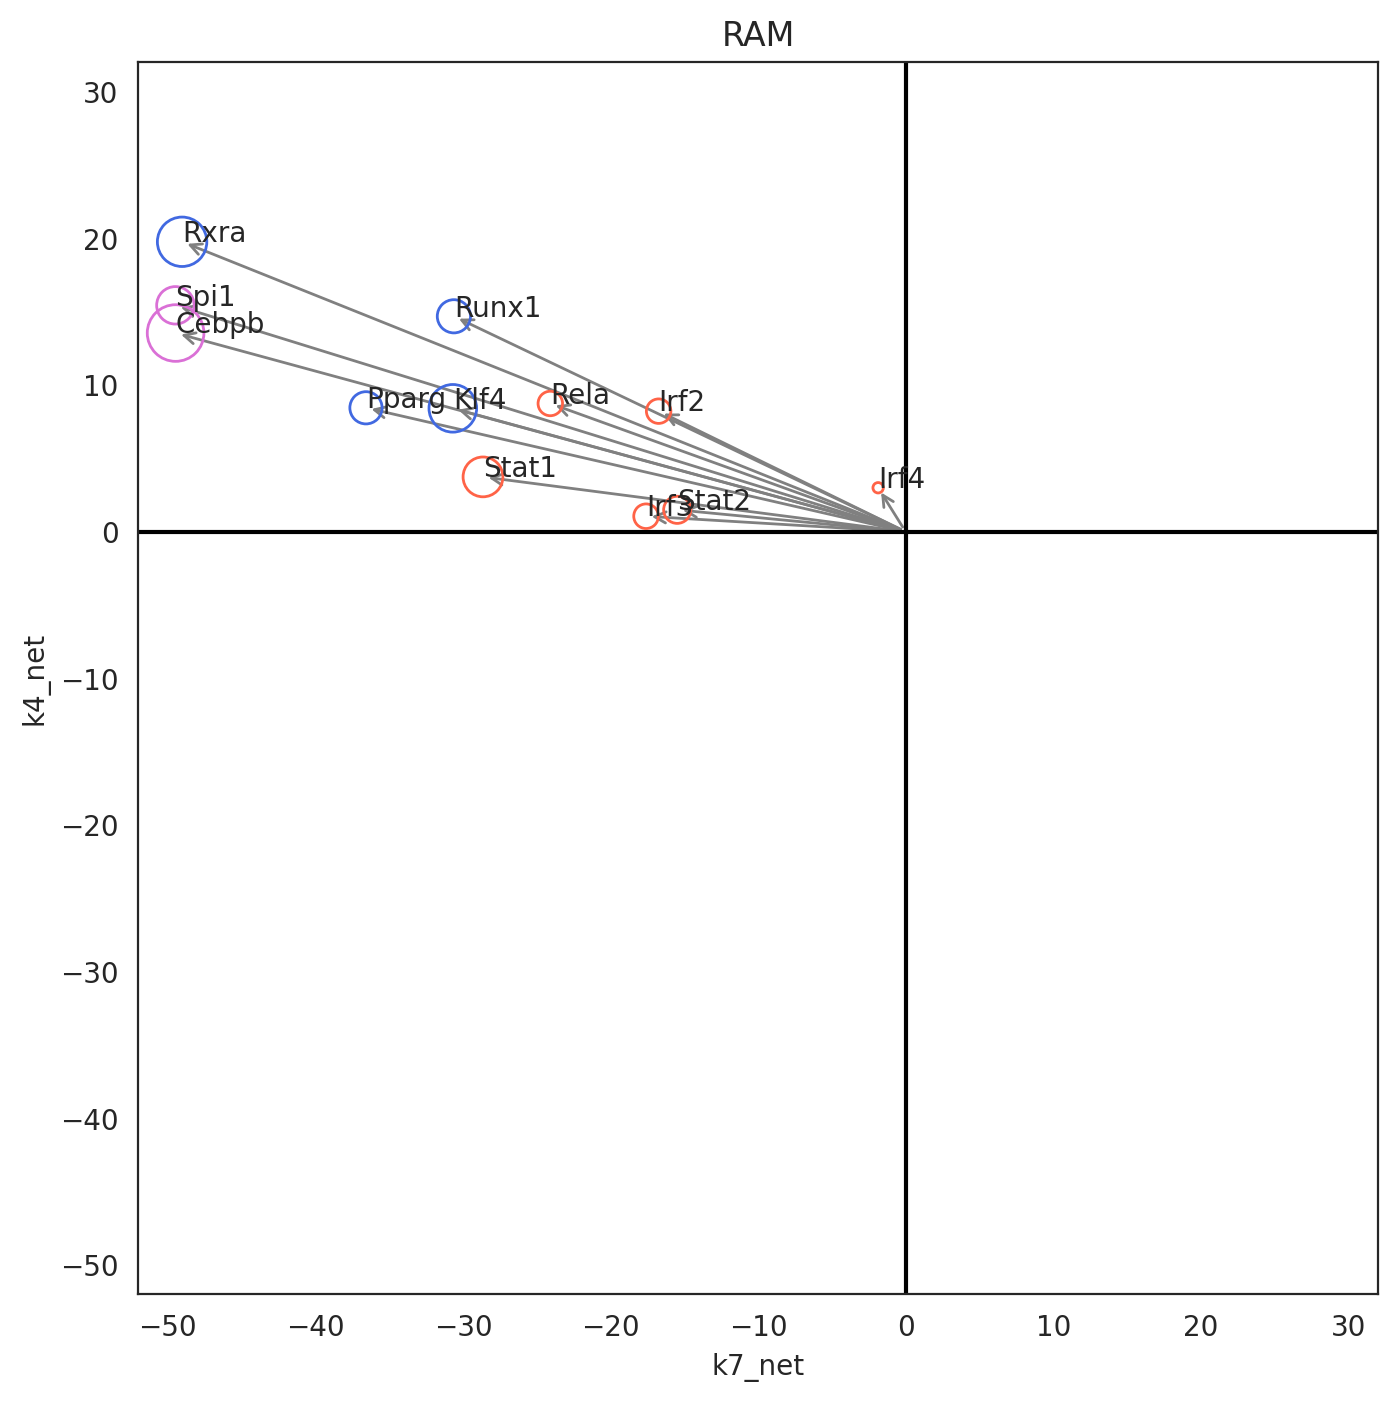

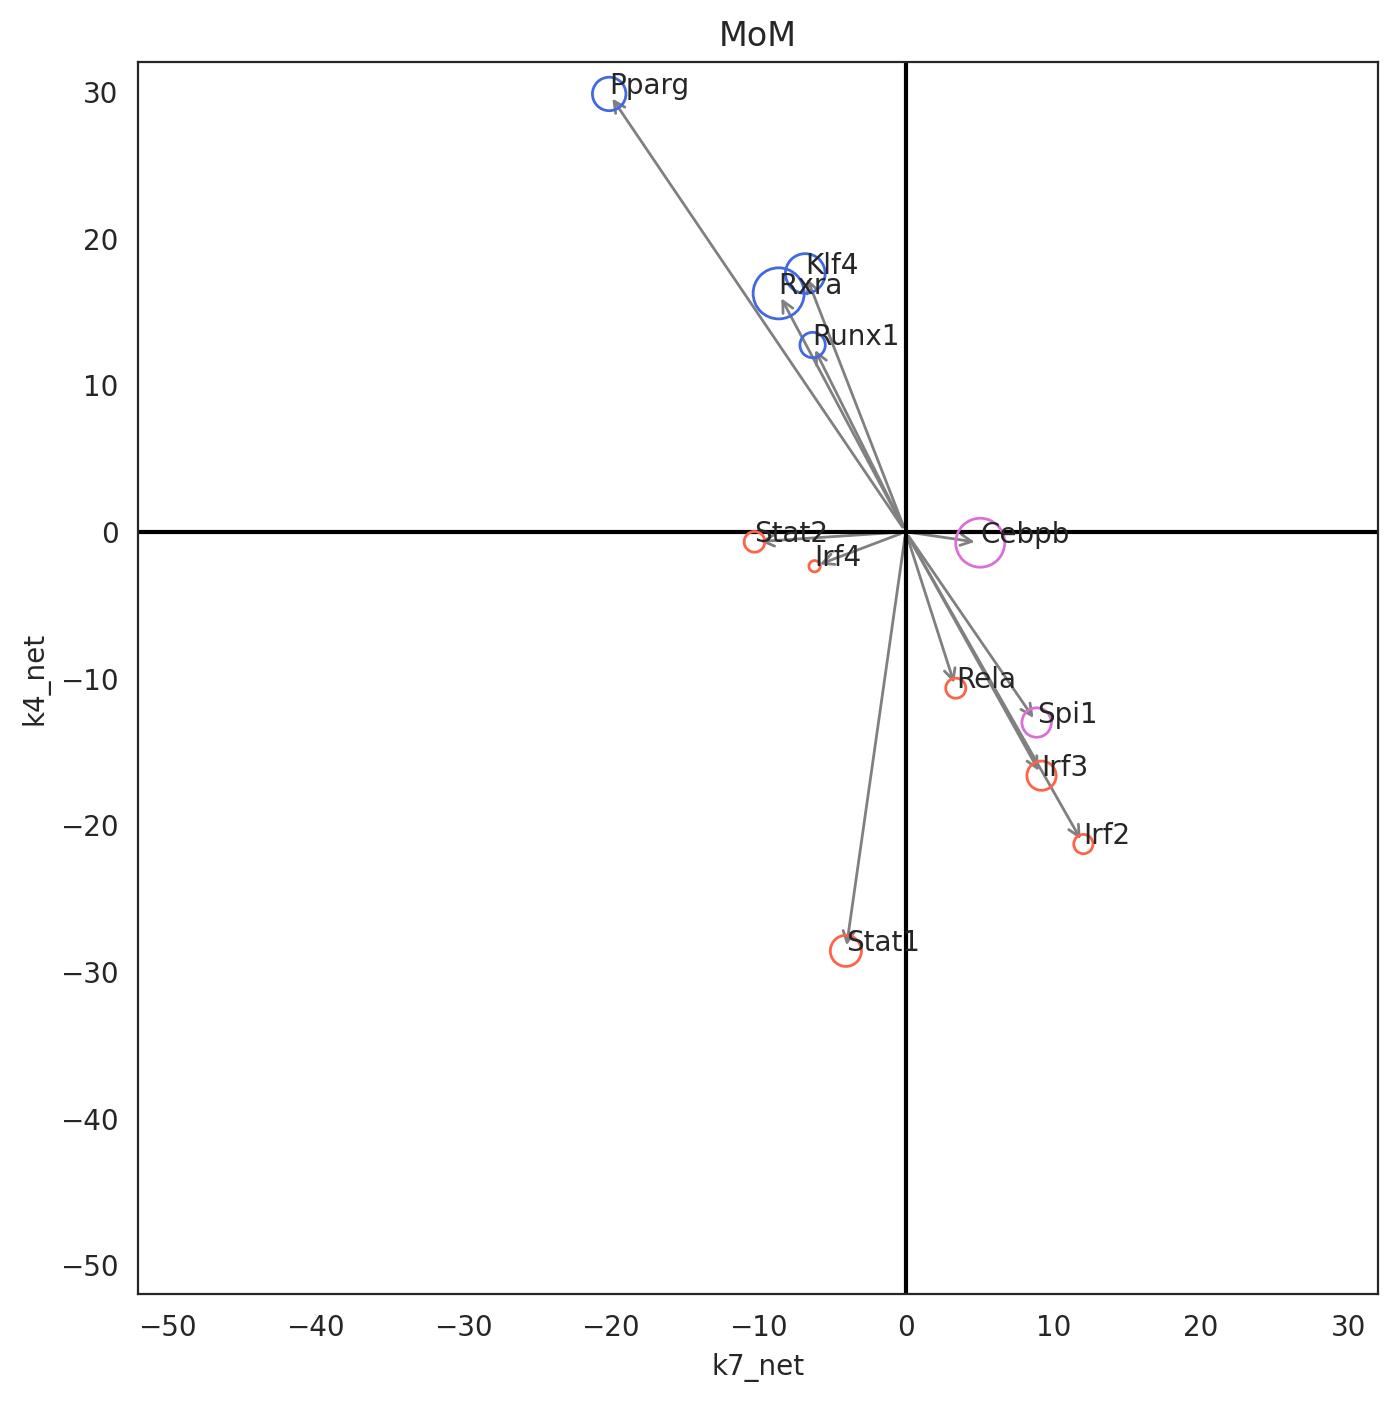

In [14]:
currx = 'k7_net'
curry = 'k4_net'
top = 20
plot_ps_quadrants(RAM_ps_df_filt, 'k7_net','k4_net', color=['orchid', 'tomato', 'royalblue'], color_metric = 'color_code', size_factor=600, ax_size=(-52, 32), thresh=-100, labels=top, arrow_color='grey', title='RAM')
plot_ps_quadrants(MoM_ps_df_filt, 'k7_net','k4_net', color=['orchid', 'tomato', 'royalblue'], color_metric = 'color_code', size_factor=600, ax_size=(-52, 32), thresh=-100, labels=top, arrow_color='grey', title='MoM')

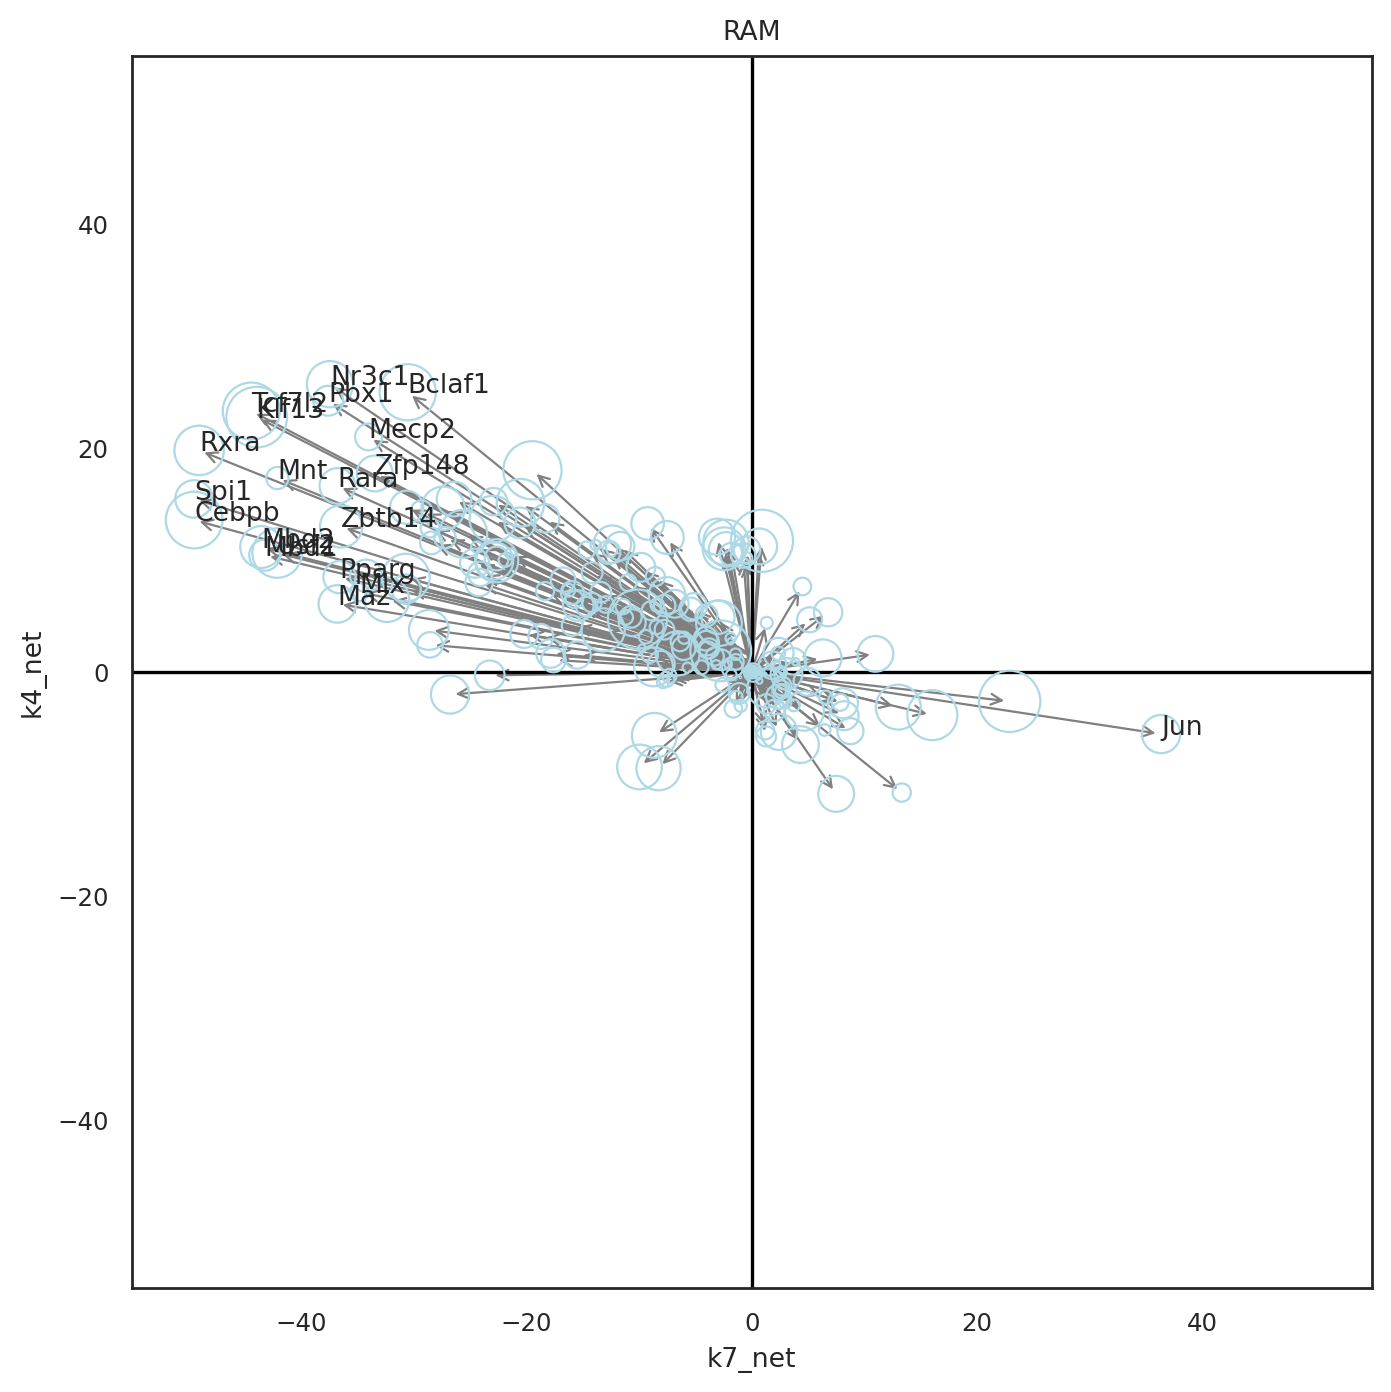

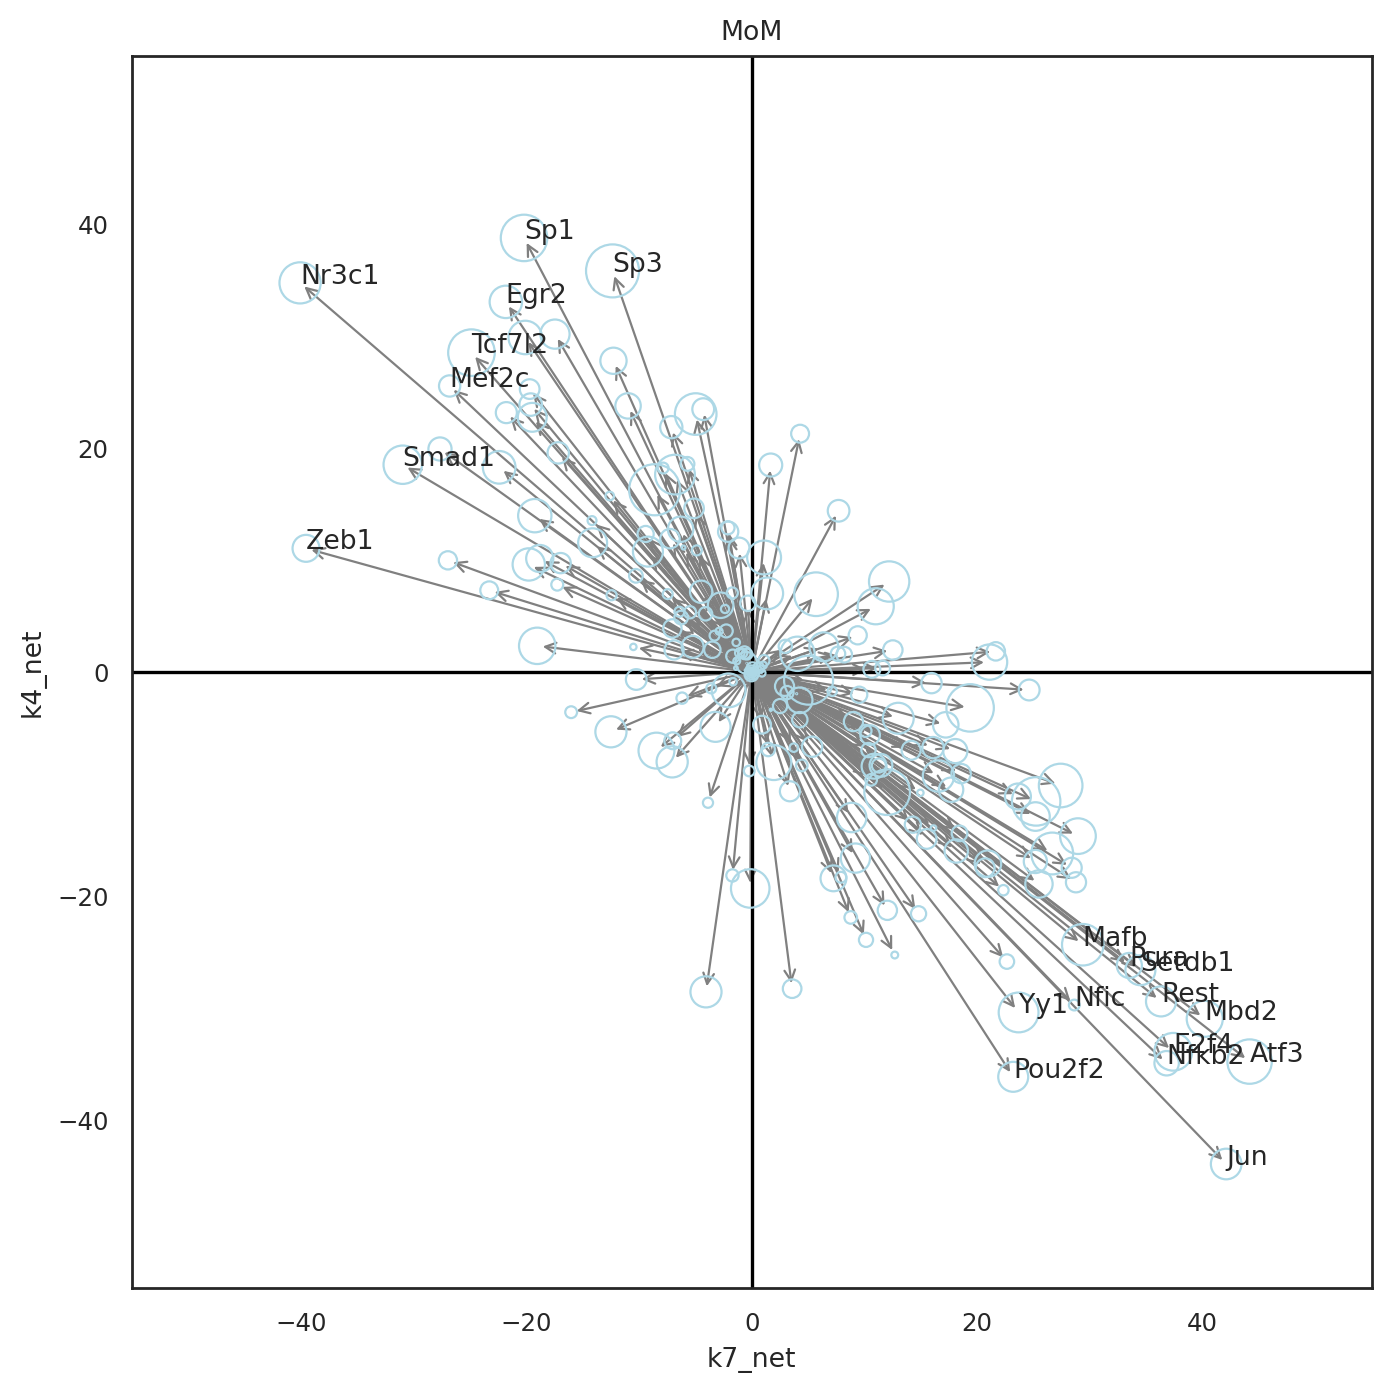

In [178]:
plot_ps_quadrants(RAM_ps_df, 'k7_net','k4_net', color='lightblue',  size_factor=600, ax_size=(-55, 55), thresh=-100, labels=top, arrow_color='grey', title='RAM')
plot_ps_quadrants(MoM_ps_df, 'k7_net','k4_net', color='lightblue',  size_factor=600, ax_size=(-55, 55), thresh=-100, labels=top, arrow_color='grey', title='MoM')

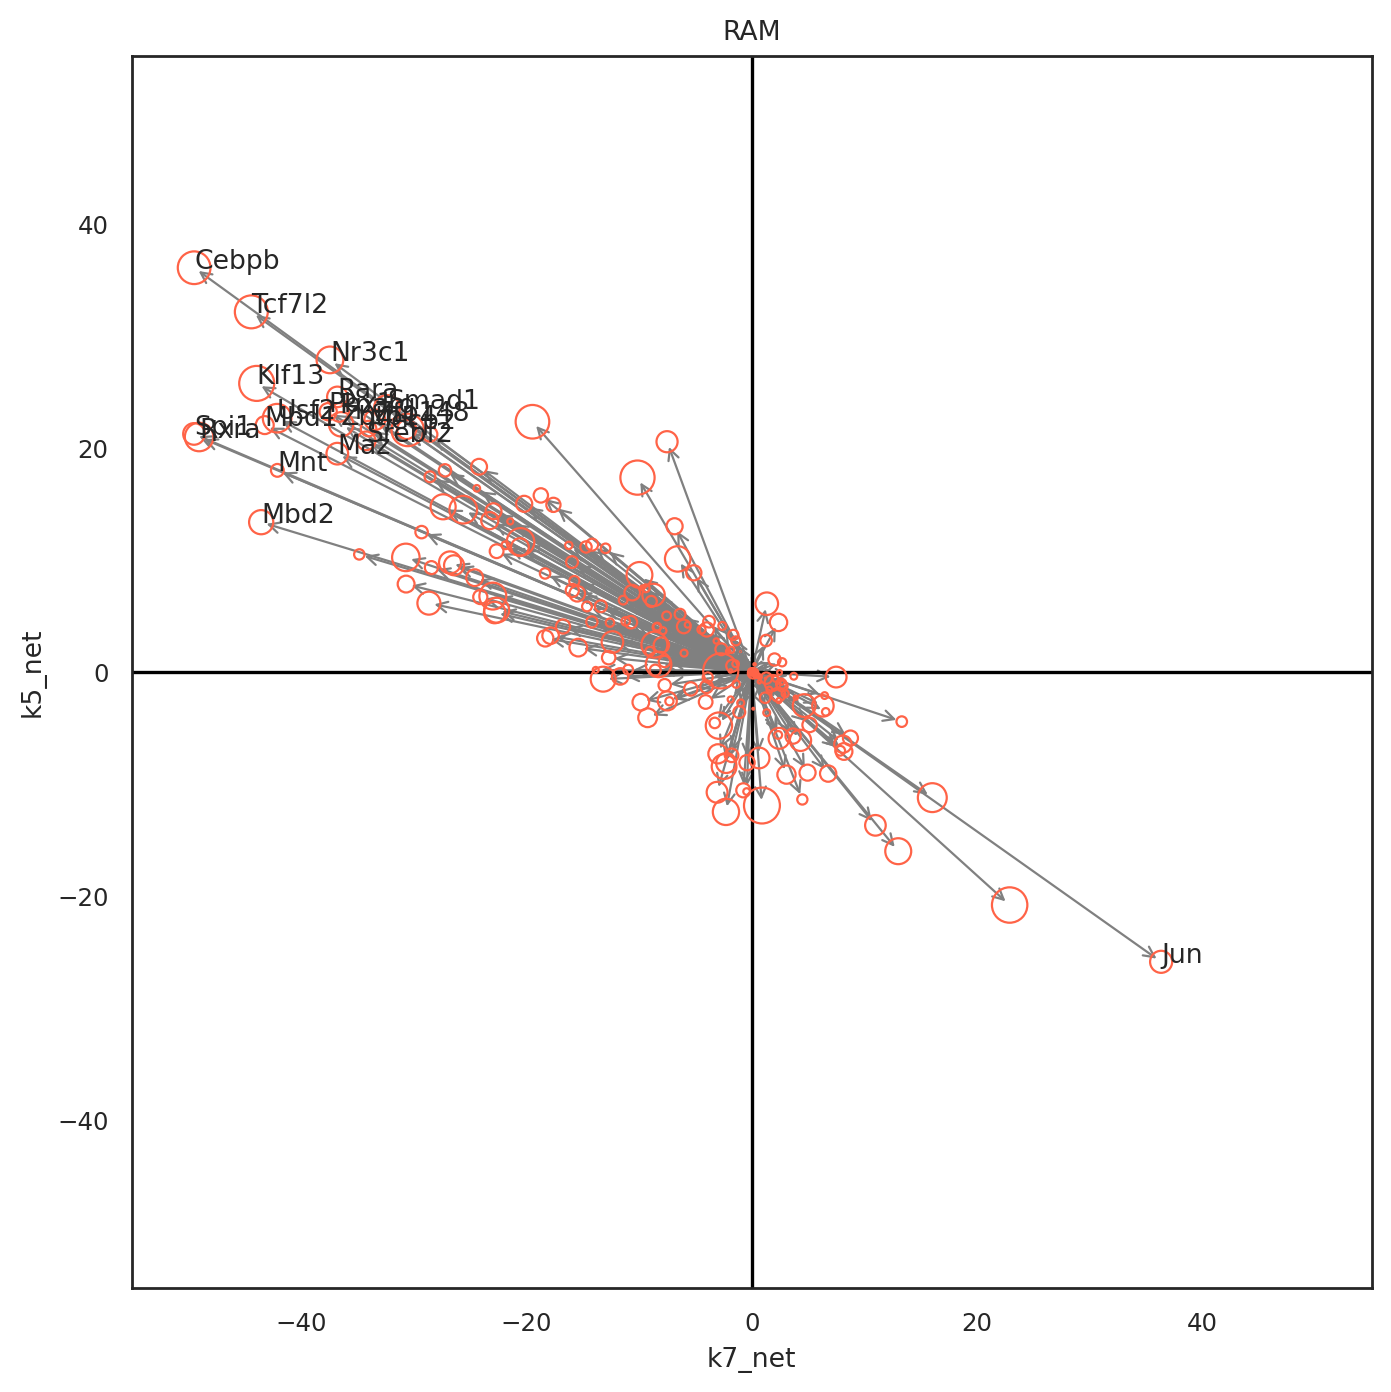

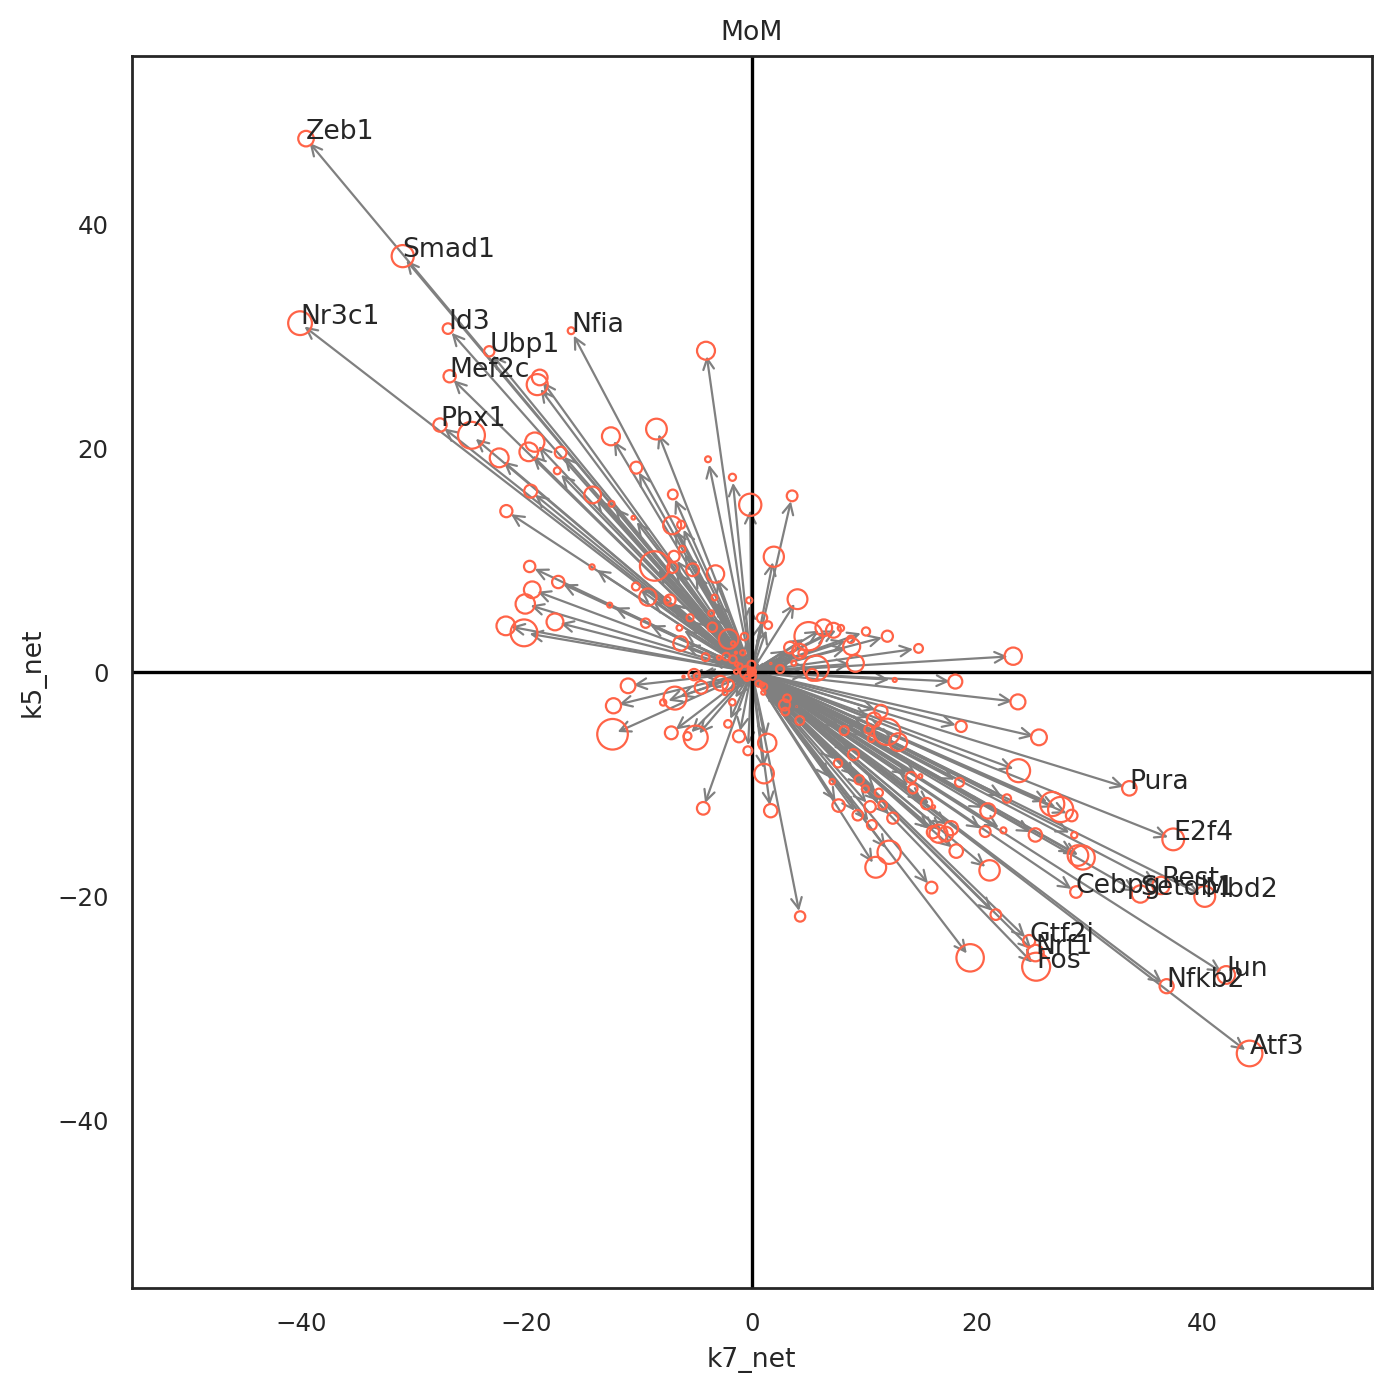

In [117]:
currx = 'k7_net'
curry = 'k5_net'
top = 20
plot_ps_quadrants(RAM_ps_df, 'k7_net','k5_net', color='tomato', ax_size=(-55, 55), thresh=-100, labels=top, arrow_color='grey', title='RAM')
plot_ps_quadrants(MoM_ps_df, 'k7_net','k5_net', color='tomato', ax_size=(-55, 55), thresh=-100, labels=top, arrow_color='grey', title='MoM')

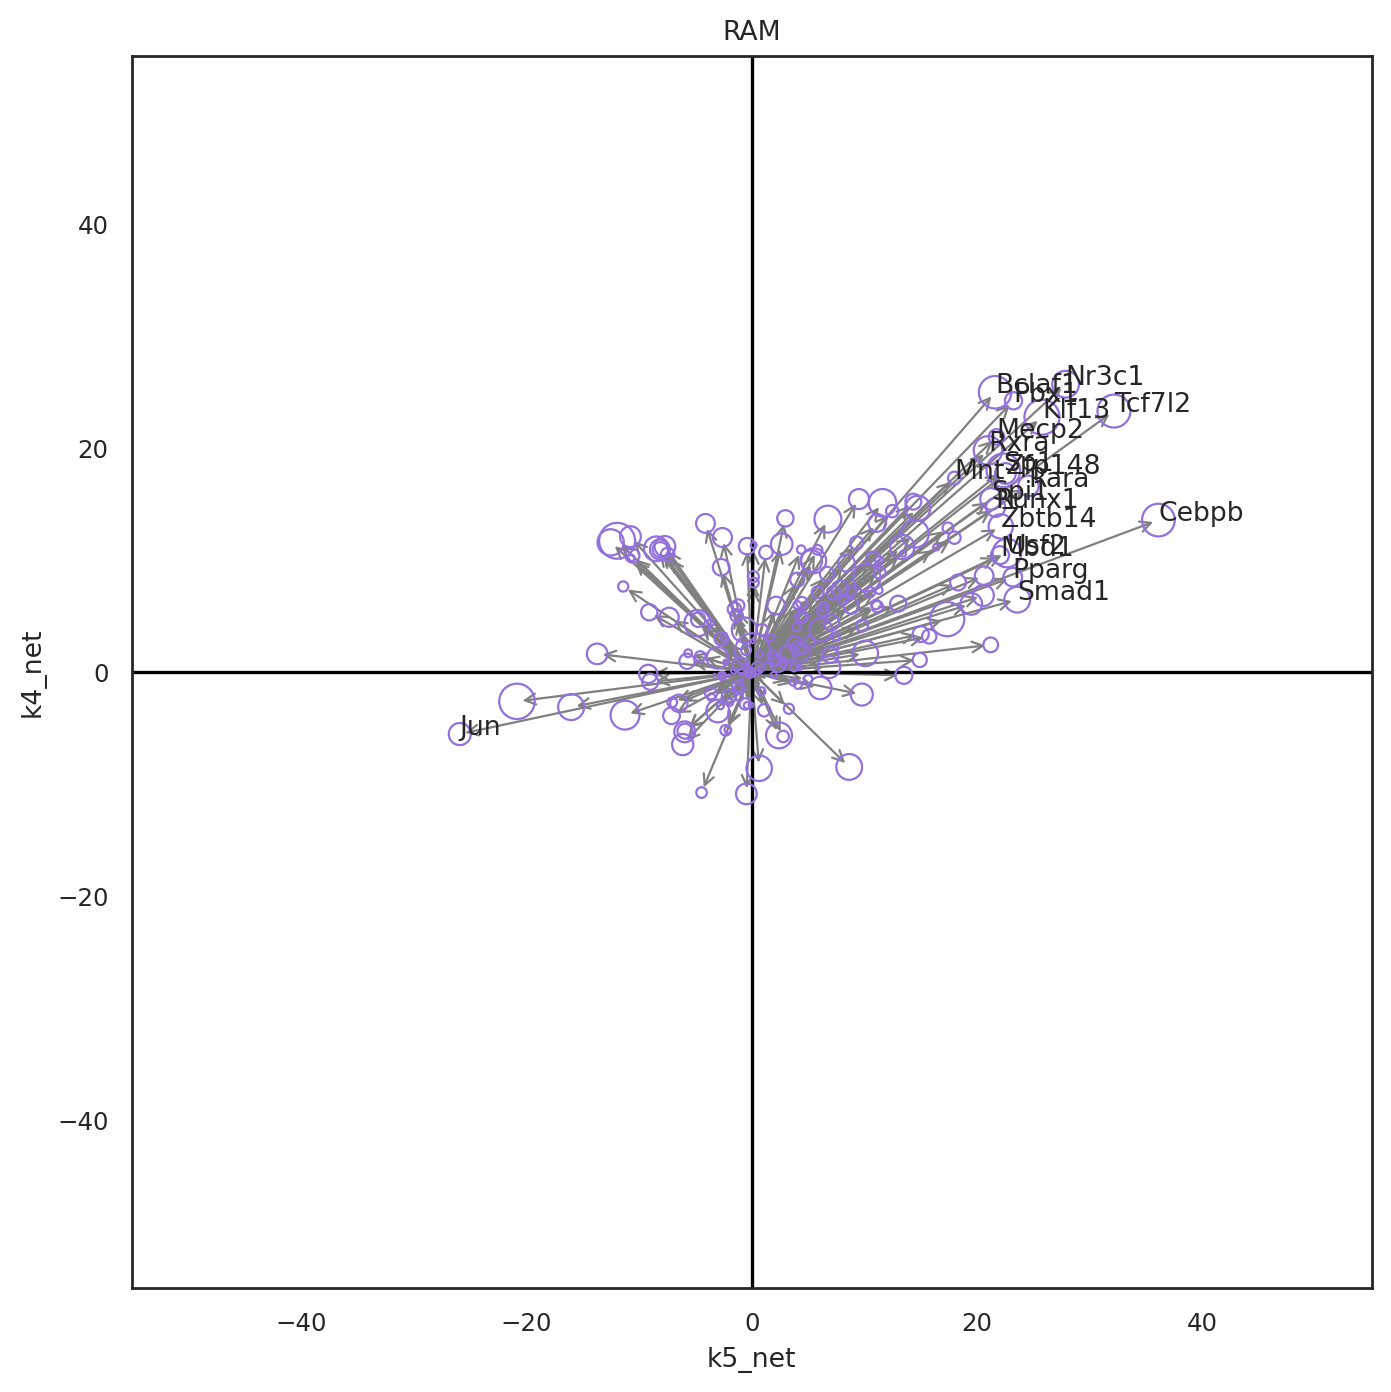

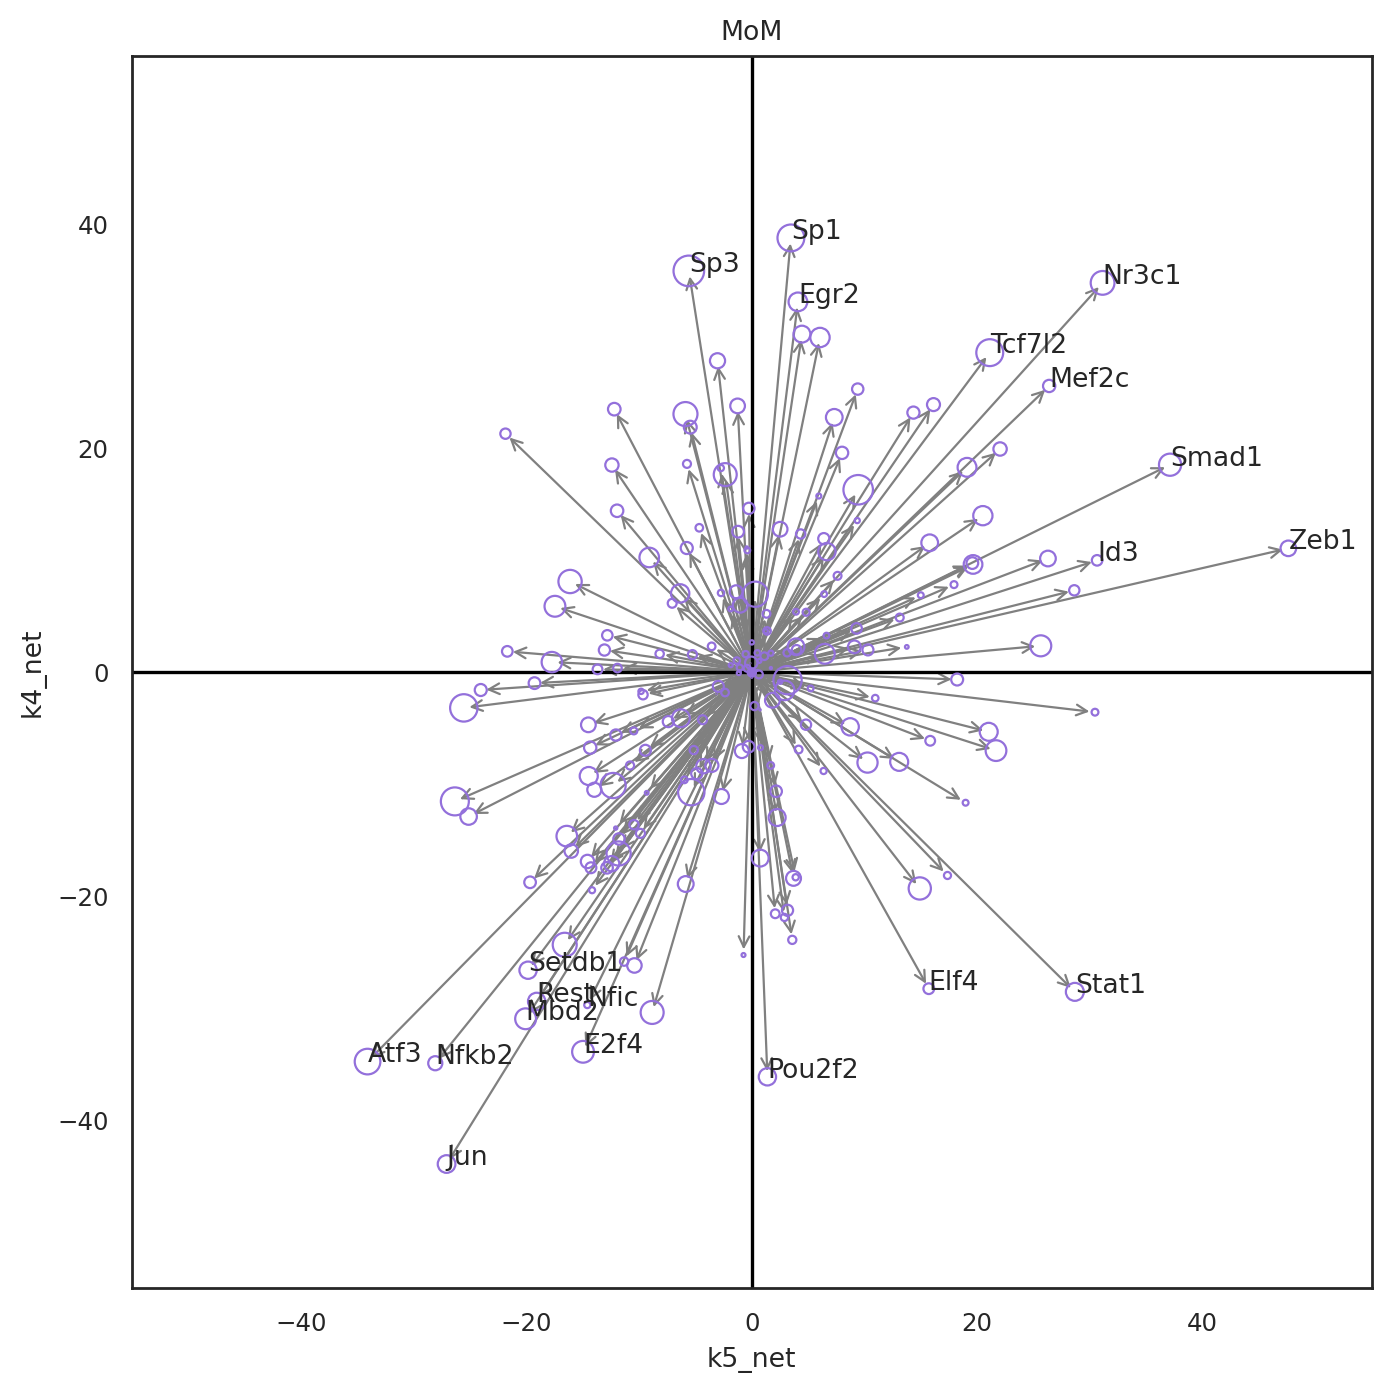

In [118]:
currx = 'k5_net'
curry = 'k4_net'
top = 20
plot_ps_quadrants(RAM_ps_df, 'k5_net','k4_net', color='mediumpurple', ax_size=(-55, 55),  thresh=-100, labels=top, arrow_color='grey', title='RAM')
plot_ps_quadrants(MoM_ps_df, 'k5_net','k4_net', color='mediumpurple', ax_size=(-55, 55),  thresh=-100, labels=top, arrow_color='grey', title='MoM')

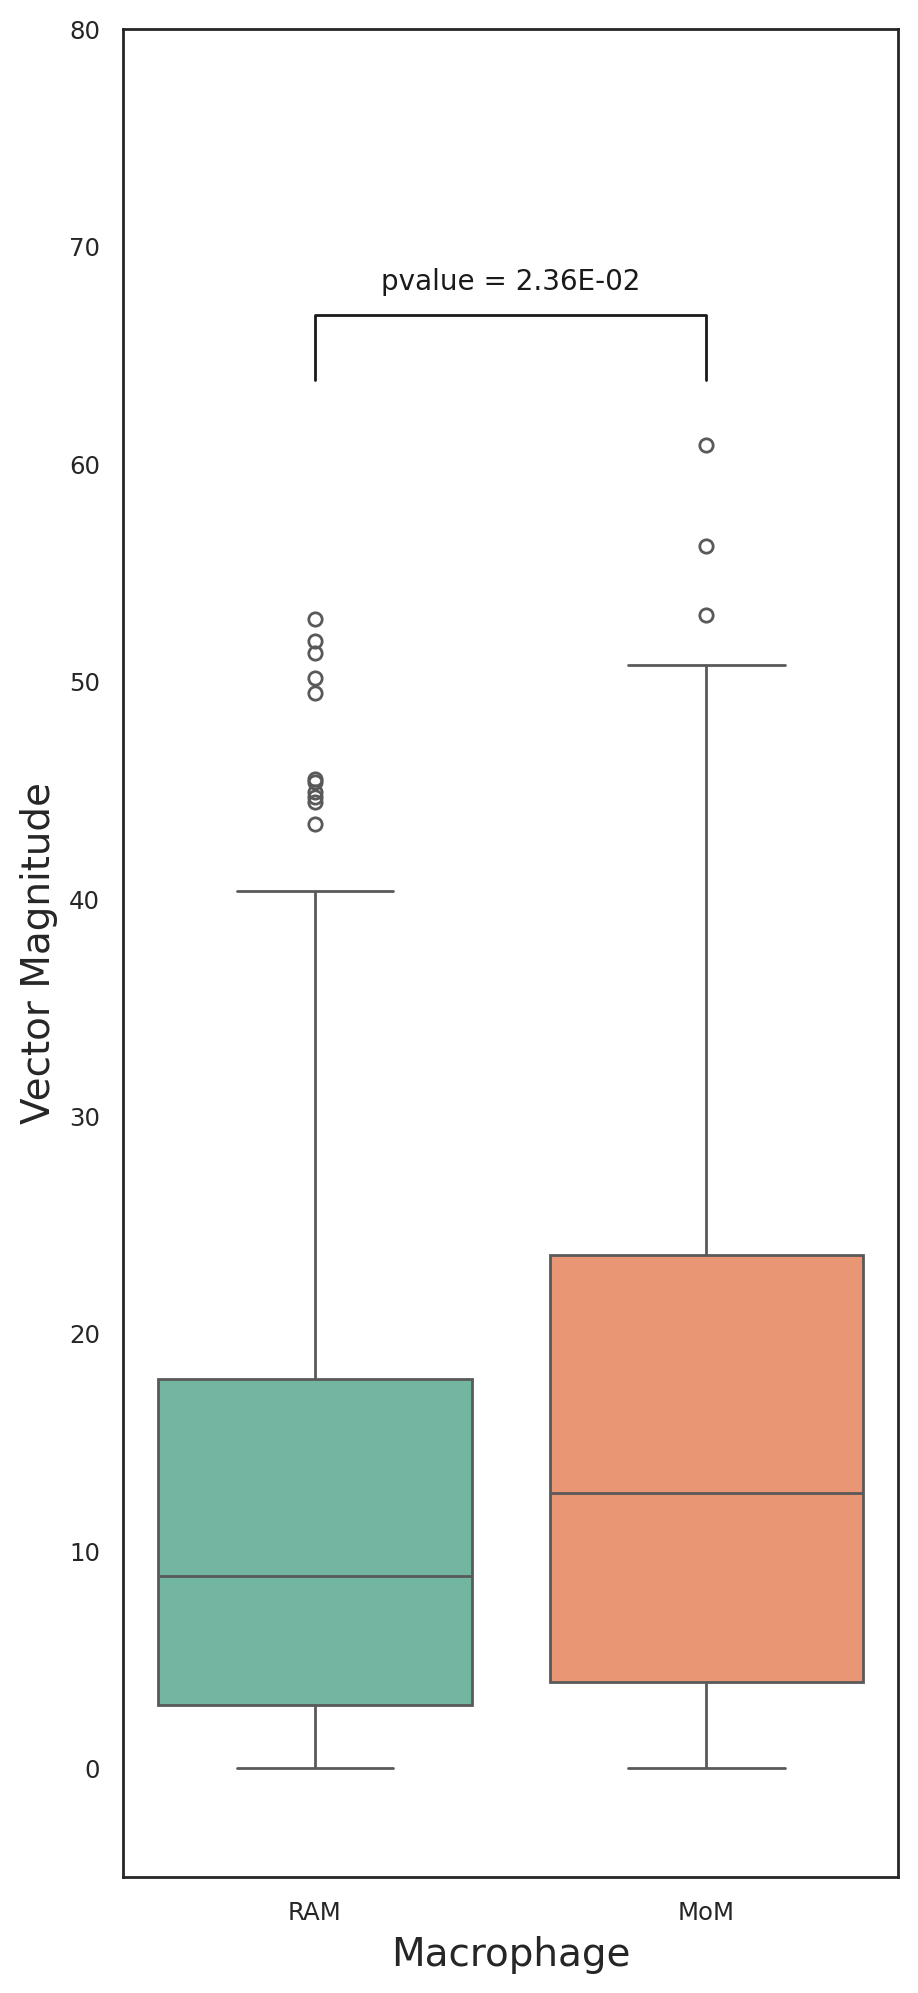

In [52]:
sns.set_theme('paper')
sns.set_style('white')
plt.figure(figsize=(5, 12))
RAM_vectors_k4k7 = getVectors(RAM_ps_df, 'k4_net', 'k7_net')
MoM_vectors_k4k5k7 = getVectors(MoM_ps_df, 'k4_net', 'k7_net')
temp = pd.concat([RAM_vectors_k4k7, MoM_vectors_k4k7], axis=1).rename(columns={0: 'RAM', 1: 'MoM'}).melt()
pval = stats.mannwhitneyu(RAM_vectors_k4k7, MoM_vectors_k4k7)
x1, x2 = 0, 1  
y, h, col = temp['value'].max() + 3, 3, 'k'
sns.boxplot(data = temp, x = 'variable', y='value', palette='Set2')
plt.ylim(-5, 80)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+(1.3*h), 'pvalue = %.2E' % (pval[1]), ha='center', va='bottom', color=col, fontsize = 10)
plt.xlabel('Macrophage', fontsize = 14)
plt.ylabel('Vector Magnitude', fontsize = 14)
#plt.savefig('20260108_momram_vectorMag.pdf')